In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
plt.style.use('science')
from pypeit.utils import calc_ivar

import warnings
warnings.filterwarnings("ignore")

In [2]:
def ivarsmooth(flux, ivar, window):
    nflux = (flux.shape)[0]
    halfwindow = int(np.floor((np.round(window) - 1)/2))
    shiftarr = np.zeros((nflux, 2*halfwindow + 1))
    shiftivar = np.zeros((nflux, 2*halfwindow + 1))
    shiftindex = np.zeros((nflux, 2*halfwindow + 1))
    indexarr = np.arange(nflux)
    indnorm = np.outer(indexarr,(np.zeros(2 *halfwindow + 1) + 1))
    for i in np.arange(-halfwindow,halfwindow + 1,dtype=int):
        shiftarr[:,i+halfwindow] = np.roll(flux,i)
        shiftivar[:, i+halfwindow] = np.roll(ivar, i)
        shiftindex[:, i+halfwindow] = np.roll(indexarr, i)
    wh = (np.abs(shiftindex - indnorm) > (halfwindow+1))
    shiftivar[wh]=0.0
    outivar = np.sum(shiftivar,axis=1)
    nzero, = np.where(outivar > 0.0)
    zeroct=len(nzero)
    smoothflux = np.sum(shiftarr * shiftivar, axis=1)
    if(zeroct > 0):
        smoothflux[nzero] = smoothflux[nzero]/outivar[nzero]
    else:
        smoothflux = np.roll(flux, 2*halfwindow + 1)

    return (smoothflux, outivar)

In [3]:
def plot(name_list, fits_list, idx_list, ylim_list, xlim_list):
    num = len(fits_list)
    fig, axs = plt.subplots(num, 1, figsize=(10,3*num))
    if num == 1:
        axs = [axs]
    for idx, ax in enumerate(axs):
        hdul = fits.open(fits_list[idx])
        output = Table(hdul[idx_list[idx]].data)
        flux = np.array(output['OPT_FLAM'])
        flux_ivar = np.array(output['OPT_FLAM_IVAR'])
        flux_err = 1 / np.sqrt(flux_ivar)
        wave = np.array(output['OPT_WAVE'])
        flux_sm, flux_ivar_sm = ivarsmooth(flux, flux_ivar, 3)

        ax.plot(wave[wave>5000], flux_sm[wave>5000], label=name_list[idx], color="black", lw=1.5)
        ax.plot(wave[wave>5000], calc_ivar(flux_ivar_sm)[wave>5000], 
                lw=1, color="red", alpha=0.6)
        ax.set_xlabel(r"wavelength ($\AA$)", fontsize=15)
        ax.set_ylabel(r"f$_{\lambda}$ ($10^{-17}$ ergs$^{-1}$cm$^{-2}\AA^{-1}$)", fontsize=15)
        # ax.set_title("J0847+0139, window=3", fontsize=20)
        ax.set_xlim(xlim_list[idx][0], xlim_list[idx][1])
        ax.set_ylim(ylim_list[idx][0], ylim_list[idx][1])
        ax.legend(loc="upper right")
    fig.tight_layout()
    return fig, axs

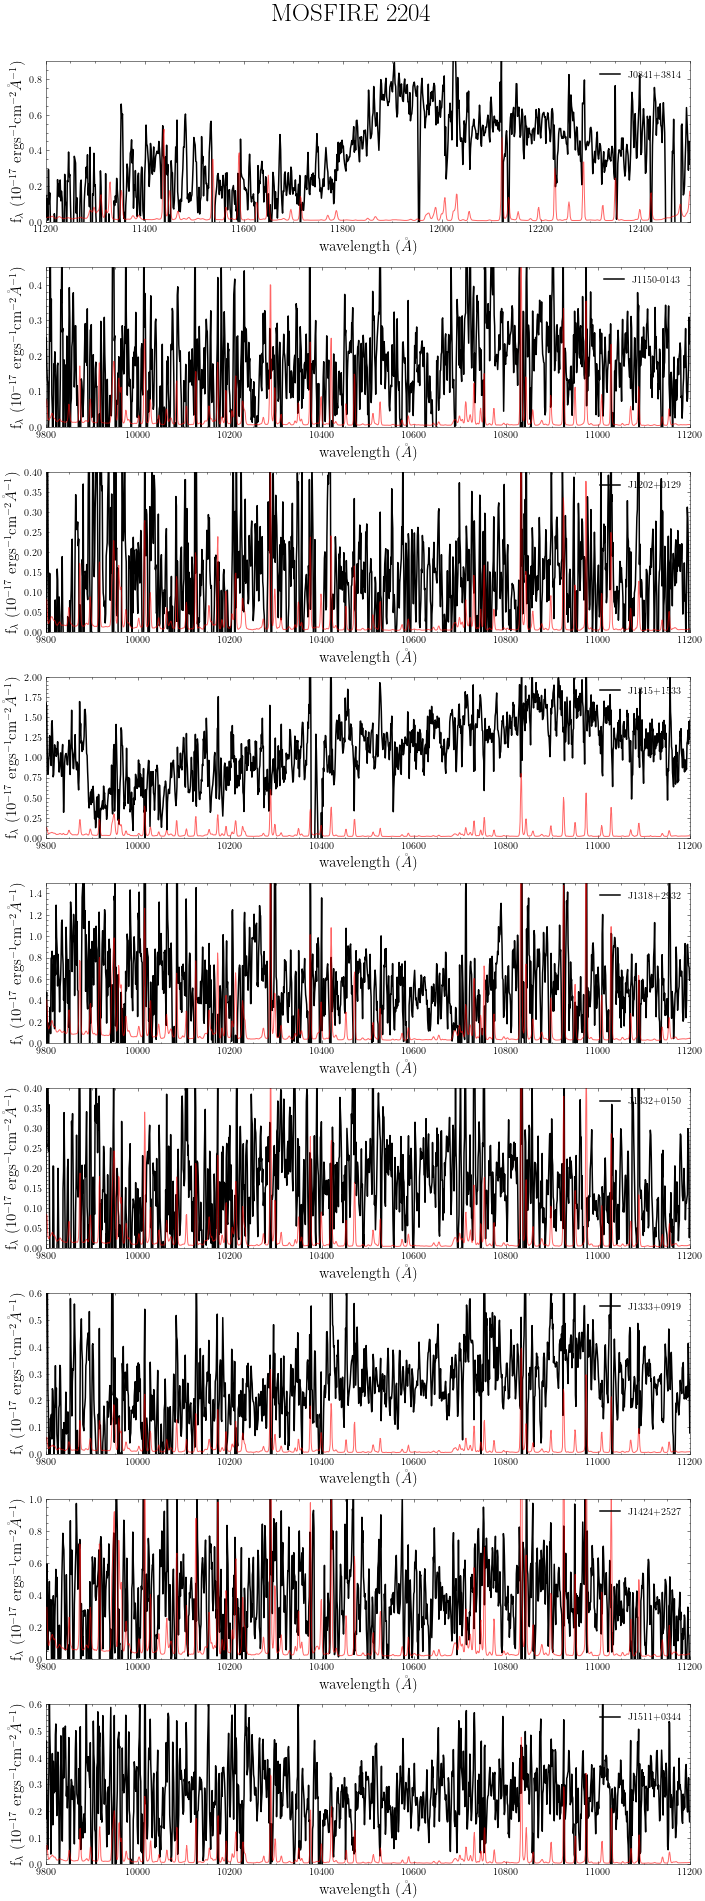

In [7]:
name_list = ["J0841+3814", "J1150-0143", "J1202+0129", "J1315+1533", "J1318+2932", "J1332+0150", "J1333+0919", "J1424+2527", "J1511+0344"]
fits_list = ["J2_test/Science_coadd/spec1d_m220409-m220409-J0841+3814.fits",
             "all/coadd2d/Science_coadd/spec1d_m220409-m220409-J1150.fits",
             "all/coadd2d/Science_coadd/spec1d_m220409-m220409-J1202+0129.fits",
             "all/coadd2d/Science_coadd/spec1d_m220409-m220409-J1315+1533.fits",
             "all/coadd2d/Science_coadd/spec1d_m220409-m220409-J1318+2932.fits",
             "all/coadd2d/Science_coadd/spec1d_m220409-m220409-J1332+0150.fits",
             "all/coadd2d/Science_coadd/spec1d_m220409-m220409-J1333+0919.fits",
             "all/coadd2d/Science_coadd/spec1d_m220409-m220409-z7.fits",
             "all/coadd2d/Science_coadd/spec1d_m220409-m220409-J1511+0344.fits"]
idx_list = [7, 5, 4, 8, 5, 8, 2, 4, 2]
ylim_list = [(0,0.9), (0,0.45), (0,0.4), (0,2), (-0.,1.5), (0,0.4), (0,0.6), (-0.0,1), (0,0.6)]
xlim_list = [(11200,12500), (9800,11200), (9800,11200), (9800,11200), (9800,11200), (9800,11200), (9800,11200), (9800,11200), (9800,11200)]
fig, axs = plot(name_list, fits_list, idx_list, ylim_list, xlim_list)
fig.suptitle("MOSFIRE 2204", fontsize=25)
fig.subplots_adjust(top=0.95)
plt.savefig("MOSFIRE_2204.pdf")